In [1]:
:ext TemplateHaskell DataKinds DeriveGeneric TypeApplications ScopedTypeVariables
:ext UndecidableInstances FlexibleContexts PartialTypeSignatures

In [2]:
import           Inference.Conjugate

import           Control.Monad                  ( foldM, replicateM )
import           Data.Dynamic                   ( Dynamic
                                                , toDyn
                                                , fromDynamic
                                                , Typeable
                                                )
import qualified Data.Sequence                 as S
import           Data.Maybe                     ( mapMaybe )
import qualified Data.Vector                   as V
import           GHC.Generics
import           Lens.Micro.TH                  ( makeLenses )
import           Numeric.SpecFunctions
import qualified Numeric.LinearAlgebra         as HM
import           System.Random.MWC.Probability
import qualified Graphics.Matplotlib           as Plt
import           IHaskellMatplotlib

# Conjugate Inference with Probabilistic Programming

## Bayesian Models

Bayesian modeling specifies a domain as a probability distribution that links observed ($x$) and latent ($z$) variables.
With Bayesian inference, we try to obtain the *posterior distribution* of the latent variables given the observations:
$$ p(z \mid x) = \dfrac{p(x, z)}{p(z)} $$

Often, the relationship between the latent and observed variables is assumed to be a generative process,
by which the observations are "generated" based on the latent variables.
In this case, the model factorizes into a *prior distribution* over latent variables $p(z)$ and a likelihood $p(x \mid z)$.
$$ p(x, z) = p(x \mid z) p(z) $$

If we have many observations generated (independently) by the same process,
some latent variables can be *global* (i.e., they affect all datapoints in the same way),
while others are *local* to each datapoint:
$$ p(x, z) = \prod_i \left( p(x_i \mid z_i^l, z^g) p(z_i^l \mid z^g) \right) p(z^g) $$

A common case is that the global variables are parameters of the probability distributions used in the likelihood:
$$ p(x, \theta) = p(\theta) p(x \mid \theta) = p(\theta) \prod_i p(x_i \mid \theta) $$
$$ p(\theta \mid x) = \dfrac{p(x \mid \theta) p(\theta)}{p(x)}$$

## Conjugate Priors

[Wikipedia](https://en.wikipedia.org/wiki/Conjugate_prior)

When the posterior of a latent variable comes from the same family of distributions as its prior,
then the posterior and prior are called *conjugate*.
Since the posterior is a result of the prior and the likelihood,
conjugacy depends on the combination of both.
For example, a beta distribution is a conjugate prior to a Bernoulli likelihood:
- prior: $\theta \sim Beta(\alpha, \beta)$
- likelihood: $\forall i: x_i \sim Bernoulli(\theta)$
- posterior: $\theta \mid x \sim Beta(\alpha', \beta')$

In this model, each $x_i$ is a local observed variable, while $\theta$ is a global latent variable
(there are no local laten variables).
Here, as in many other cases, the posterior distribution can be obtained analytically:
- $\alpha' = \alpha + \sum_i x_i = \alpha + s$
- $\beta' = \beta + \sum_i (1 - x_i) = \beta + f$

for $s$ successes and $f$ failures.

## Locally Conjugate Models

If we have a model that factorizes into a prior distribution over independent global variables
and a likelihood that uses these global variables directly in a sequence of observable choices
that form conjugate pairs with the priors,
then the inference process can be performed analytically.

Example:

The global parameters consist of a coin probability $\theta$
and two categorical probability vectors $cat1$ and $cat2$.
They are drawn independently from the following priors:
- $\theta \sim Beta(0.5, 0.5)$
- $cat1 \sim Dirichlet_3(0.5)$
- $cat2 \sim Dirichlet_3(0.5)$

The likelihood uses these probabilities to generate the following observed variables:
- $coin \sim Bernoulli(\theta)$
- if $coin = 1$
  - then $category \sim Categorical_3(cat1)$
  - else $category \sim Categorical_3(cat2)$
  
Thus, for every execution of the generative process described in the likelihood,
we observe all values sampled in the process, which allows us to re-trace it,
for example $coin = 1, category = 0$.

# Expressing a Model in Code

## Global Variables and Priors

Since all variables in the prior are independent,
we can express it through a collection of variables with individual priors,
e.g. a record:

In [3]:
-- An example of a record that describes global variables.
-- It can be instantiated with different type constructors for 'f' (kind @* -> *@),
-- which allows it to represent both the hyperparameters and parameters of the model.
data ExampleParams f =
  ExampleParams { _epTheta :: f Beta
                , _epCat1 :: f (Dirichlet 3)
                , _epCat2 :: f (Dirichlet 3)
                }
  deriving (Generic)

Let's add a bit of extra code to make it easier to work with this record:

In [4]:
-- We need lenses to the fields of ExampleParams, which can be generated automatically.
makeLenses ''ExampleParams

-- The Show instance for ExampleParams needs to be standalone
-- because of the Show (f p l) constraints that GHC can't figure out on its own.
-- Here we specify it manually for nicer output.
instance ( Show (f Beta)
         , Show (f (Dirichlet 3)))
         => Show (ExampleParams f) where
  show (ExampleParams p cat1 cat2) =
    "ExampleParams"
      <> "\n  epTheta = "
      <> show p
      <> "\n  epCat1  = "
      <> show cat1
      <> "\n  epCat2  = "
      <> show cat2

This record can be instantiated in different ways, e.g. to represent the values of the global variables:

In [5]:
-- newtype ProbsRep p = ProbsRep { runProbs :: Probs (AsPrior p)}

exampleProbs :: ExampleParams ProbsRep
exampleProbs = ExampleParams { _epTheta = ProbsRep 0.7
                             , _epCat1  = ProbsRep $ V.fromList [0.3, 0.1, 0.6]
                             , _epCat2  = ProbsRep $ V.fromList [0.1, 0.8, 0.1]
                             }

exampleProbs

ExampleParams
  epTheta = ProbsRep {runProbs = 0.7}
  epCat1  = ProbsRep {runProbs = [0.3,0.1,0.6]}
  epCat2  = ProbsRep {runProbs = [0.1,0.8,0.1]}

... or the parameters of the priors:

In [6]:
-- newtype HyperRep p = HyperRep { runHyper :: Hyper (AsPrior p) }

examplePrior :: ExampleParams HyperRep
examplePrior = ExampleParams { _epTheta = HyperRep (0.5, 0.5)
                              , _epCat1  = HyperRep $ V.fromList [0.5, 0.5, 0.5]
                              , _epCat2  = HyperRep $ V.fromList [0.5, 0.5, 0.5]
                              }

examplePrior

ExampleParams
  epTheta = HyperRep {runHyper = (0.5,0.5)}
  epCat1  = HyperRep {runHyper = [0.5,0.5,0.5]}
  epCat2  = HyperRep {runHyper = [0.5,0.5,0.5]}

The two helper types `ProbsRep` and `HyperRep` instantiate the fields of the record with the appropriate types
for the support and the parameters of the prior distribution, respectively.
These are defined as type-level functions on the distribution types, e.g.:
```haskell
Hyper (AsPrior Beta) = Params  Beta = (Double, Double)
Probs (AsPrior Beta) = Support Beta = Double
```

For standard priors such as the Jeffreys prior, we can automatically generate the corresponding values
using the `Generics` instance of `ExampleParams`:

In [7]:
-- jeffreysPrior :: forall a. Jeffreys a => Hyper a
priorJ = jeffreysPrior @ExampleParams
priorJ

ExampleParams
  epTheta = HyperRep {runHyper = (0.5,0.5)}
  epCat1  = HyperRep {runHyper = [0.5,0.5,0.5]}
  epCat2  = HyperRep {runHyper = [0.5,0.5,0.5]}

In [8]:
-- uniformPrior :: forall a. Jeffreys a => Hyper a
priorU = uniformPrior @ExampleParams
priorU

ExampleParams
  epTheta = HyperRep {runHyper = (1.0,1.0)}
  epCat1  = HyperRep {runHyper = [1.0,1.0,1.0]}
  epCat2  = HyperRep {runHyper = [1.0,1.0,1.0]}

Similarly, we can generically sample values for the global variables from a given prior:

In [9]:
-- create a random generator
gen <- createSystemRandom

-- sample global variables from the prior
probs <- sample (sampleProbs @ExampleParams priorJ) gen
probs

ExampleParams
  epTheta = ProbsRep {runProbs = 0.4668138271645384}
  epCat1  = ProbsRep {runProbs = [0.3878981251320626,0.6058154926997033,6.286382168234199e-3]}
  epCat2  = ProbsRep {runProbs = [0.24570421482556076,0.7533156307274261,9.80154447013114e-4]}

## Likelihood

The likelihood can be a more complex process than the prior (in which all variables are independent),
so we express it as a probabilistic program.
This program is polymorphic, so it can be run by different "interpreters" for different purposes.

The key function here is `sampleValue`, which takes a distribution and a lens into the global record.
When generating samples, this lens is used to obtain the value of the global variable.
During inference, it is used to update the prior into the posterior.

In [10]:
-- The likelihood of the example model, described as a probabilistic program.
-- 'm' is the type variable that stands for the interpreter the program is run with.
exampleLk :: _ => RandomInterpreter m ExampleParams => m Int
exampleLk = do
  coin <- sampleValue "coin" Bernoulli epTheta
  sampleValue "cat" (Categorical @3) $ if coin then epCat1 else epCat2

Using the global variables sampled above, we can sample a datapoint from this likelihood:

In [11]:
(result, trace) <- sampleTrace probs exampleLk gen
(result, trace)

(1,Trace {runTrace = fromList [<<Bool>>,<<Int>>]})

Since the trace is a bit mysterious like this, let's use the likelihood program again to display the trace with a bit more contextual information:

In [12]:
putStrLn "trace:"
printTrace trace exampleLk

trace:

Sampled value False from a Bernoulli at coin.
Sampled value 1 from a Categorical 3 at cat.

Similarly, we can evaluate the probability of the trace:

In [13]:
logp = snd <$> evalTraceLogP probs trace exampleLk
logp

Just (-0.9121555981248599)

## Inference

We can "observe" a trace to update the prior parameters to the posterior using again our likelihood program.

In [14]:
getPosterior priorJ trace exampleLk

Just ExampleParams
  epTheta = HyperRep {runHyper = (0.5,1.5)}
  epCat1  = HyperRep {runHyper = [0.5,0.5,0.5]}
  epCat2  = HyperRep {runHyper = [0.5,1.5,0.5]}

If we want to do the same with a set of observations from a dataset,
we have to express each observation as a trace:

In [15]:
observations =
        [ Trace $ S.fromList [toDyn True, toDyn (0 :: Int)]
        , Trace $ S.fromList [toDyn False, toDyn (1 :: Int)]
        , Trace $ S.fromList [toDyn True, toDyn (0 :: Int)]
        , Trace $ S.fromList [toDyn False, toDyn (2 :: Int)]
        , Trace $ S.fromList [toDyn True, toDyn (0 :: Int)]
        , Trace $ S.fromList [toDyn False, toDyn (1 :: Int)]
        , Trace $ S.fromList [toDyn False, toDyn (2 :: Int)]
        , Trace $ S.fromList [toDyn False, toDyn (1 :: Int)]
        , Trace $ S.fromList [toDyn True, toDyn (1 :: Int)]
        , Trace $ S.fromList [toDyn False, toDyn (1 :: Int)]
        , Trace $ S.fromList [toDyn True, toDyn (2 :: Int)]
        , Trace $ S.fromList [toDyn False, toDyn (2 :: Int)]
        , Trace $ S.fromList [toDyn True, toDyn (0 :: Int)]
        , Trace $ S.fromList [toDyn False, toDyn (1 :: Int)]
        , Trace $ S.fromList [toDyn False, toDyn (2 :: Int)]
        , Trace $ S.fromList [toDyn False, toDyn (0 :: Int)]
        ]

Then we can update the prior (here the Jeffreys prior) by iterating over the observations.

In [16]:
-- foldM goes over all traces and updates the hyperparameters every time
Just posteriorJ = foldM (\hyper obs -> getPosterior hyper obs exampleLk) priorJ observations
posteriorJ

ExampleParams
  epTheta = HyperRep {runHyper = (6.5,10.5)}
  epCat1  = HyperRep {runHyper = [4.5,1.5,1.5]}
  epCat2  = HyperRep {runHyper = [1.5,5.5,4.5]}

If we use a different prior, the results will be slightly different,
but the more observations we have, the smaller the difference.

In [17]:
Just posteriorU = foldM (\hyper obs -> getPosterior hyper obs exampleLk) priorU observations
posteriorU

ExampleParams
  epTheta = HyperRep {runHyper = (7.0,11.0)}
  epCat1  = HyperRep {runHyper = [5.0,2.0,2.0]}
  epCat2  = HyperRep {runHyper = [2.0,6.0,5.0]}

Voila!

In [18]:
plotExampleParams' title (ExampleParams (HyperRep (a, b)) (HyperRep counts1) (HyperRep counts2)) =
  Plt.readData (counts1, counts2, (a,b), title) 
  Plt.% Plt.mp Plt.# "import numpy as np"
  Plt.% Plt.mp Plt.# "import ternary"
  Plt.% Plt.mp Plt.# "from scipy.stats import dirichlet, beta"
  Plt.% Plt.mp Plt.# "counts1 = np.array(data[0])"
  Plt.% Plt.mp Plt.# "counts2 = np.array(data[1])"
  Plt.% Plt.mp Plt.# "a, b = data[2]"
  Plt.% Plt.mp Plt.# "fig, ax = plot.subplots(1, 3, figsize=(15,5))"
  Plt.% Plt.mp Plt.# "x = np.linspace(0,1,100)"
  Plt.% Plt.mp Plt.# "ax[0].plot(x, beta.pdf(x, a, b))"
  Plt.% Plt.mp Plt.# "ax[0].set_title('epTheta')"
  Plt.% Plt.mp Plt.# "_, axCat1 = ternary.figure(ax=ax[1], scale=75)"
  Plt.% Plt.mp Plt.# "axCat1.heatmapf(lambda p: dirichlet.pdf(np.array(p), counts1), boundary=False, colorbar=False)"
  Plt.% Plt.mp Plt.# "axCat1.set_title('epCat1')"
  Plt.% Plt.mp Plt.# "axCat1.get_axes().axis('off')"
  Plt.% Plt.mp Plt.# "_, axCat2 = ternary.figure(ax=ax[2], scale=75)"
  Plt.% Plt.mp Plt.# "axCat2.heatmapf(lambda p: dirichlet.pdf(np.array(p), counts2), boundary=False, colorbar=False)"
  Plt.% Plt.mp Plt.# "axCat2.set_title('epCat2')"
  Plt.% Plt.mp Plt.# "axCat2.get_axes().axis('off')"
  Plt.% Plt.mp Plt.# "fig.suptitle(data[3], fontsize=20)"
  Plt.% Plt.mp Plt.# "fig.tight_layout()"

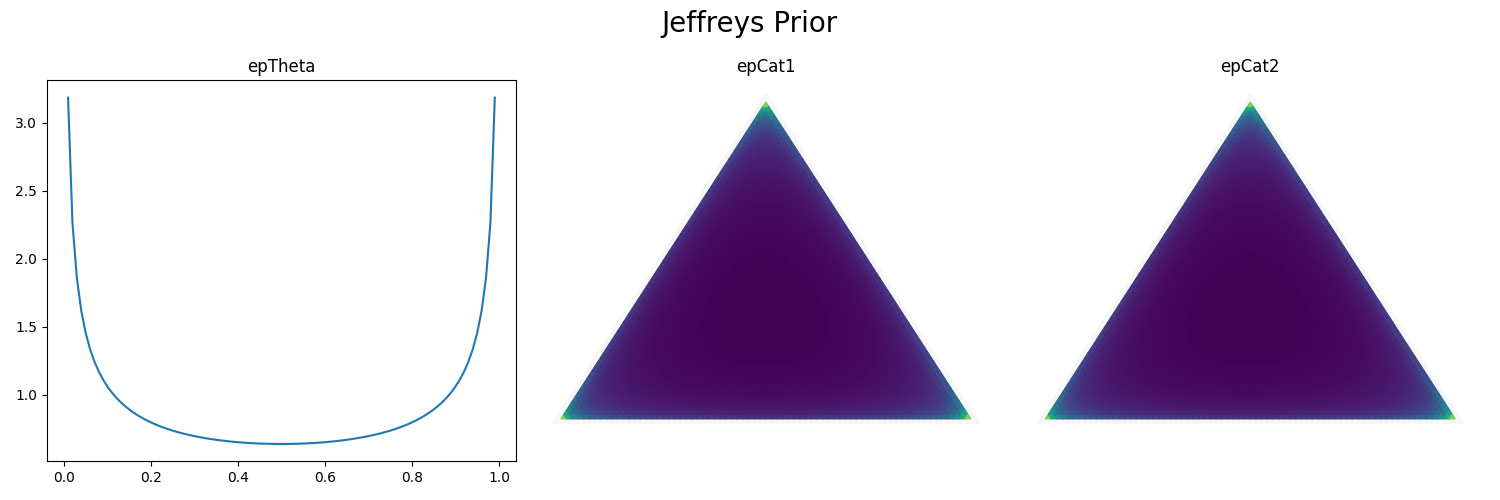

In [19]:
displayPNG 0 0 $ plotExampleParams' "Jeffreys Prior" priorJ

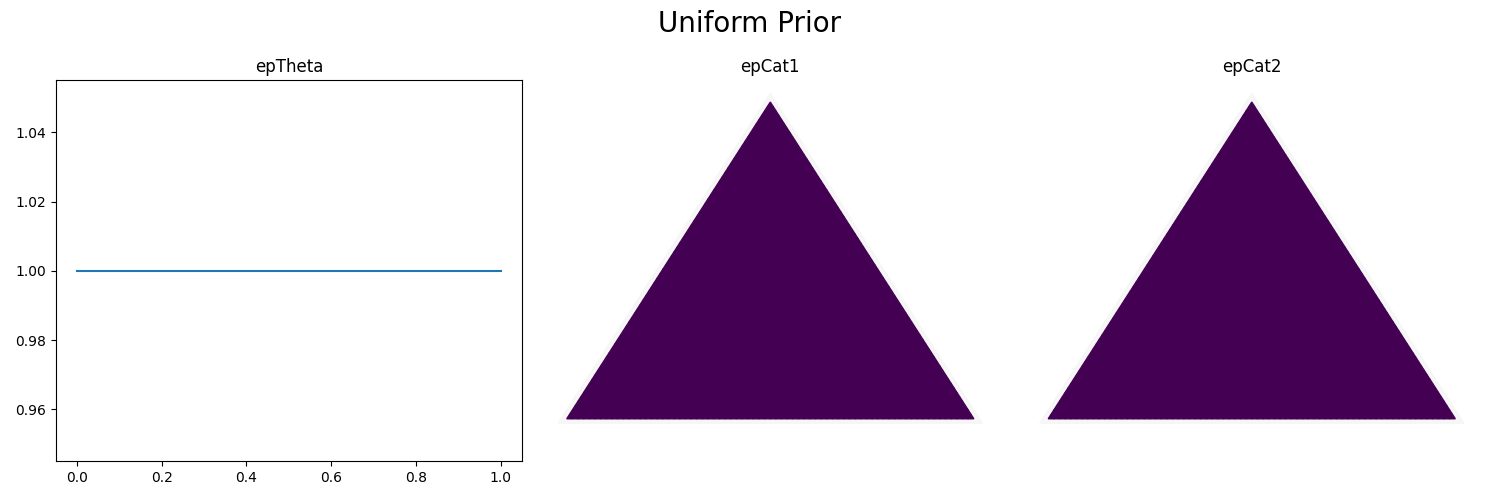

In [20]:
displayPNG 0 0 $ plotExampleParams' "Uniform Prior" priorU

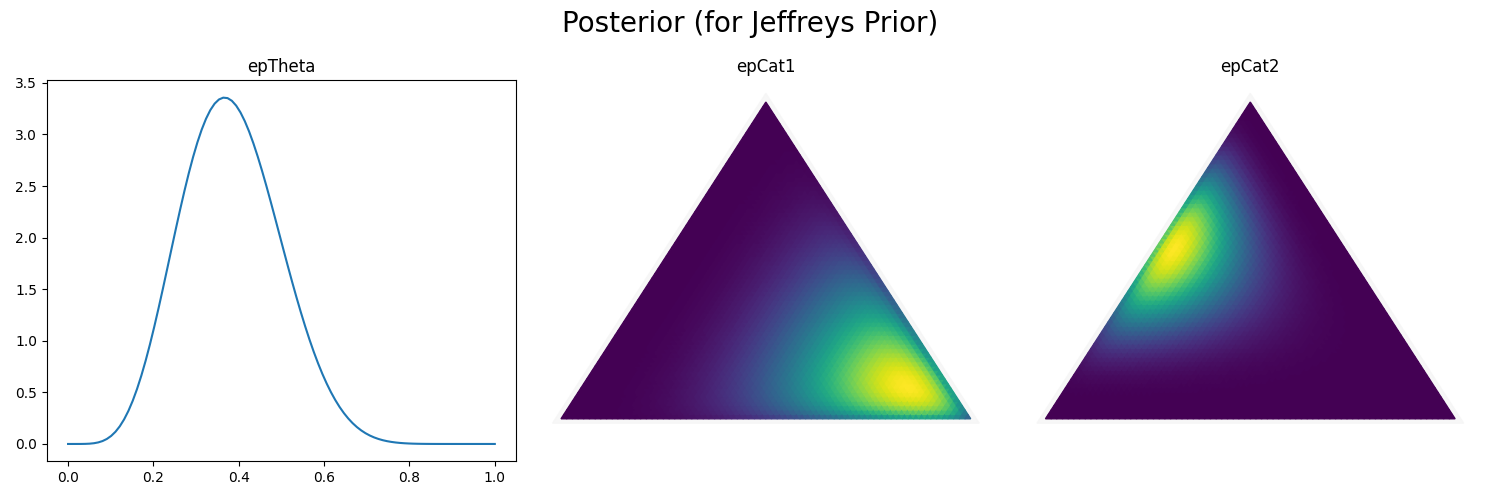

In [21]:
displayPNG 0 0 $ plotExampleParams' "Posterior (for Jeffreys Prior)" posteriorJ

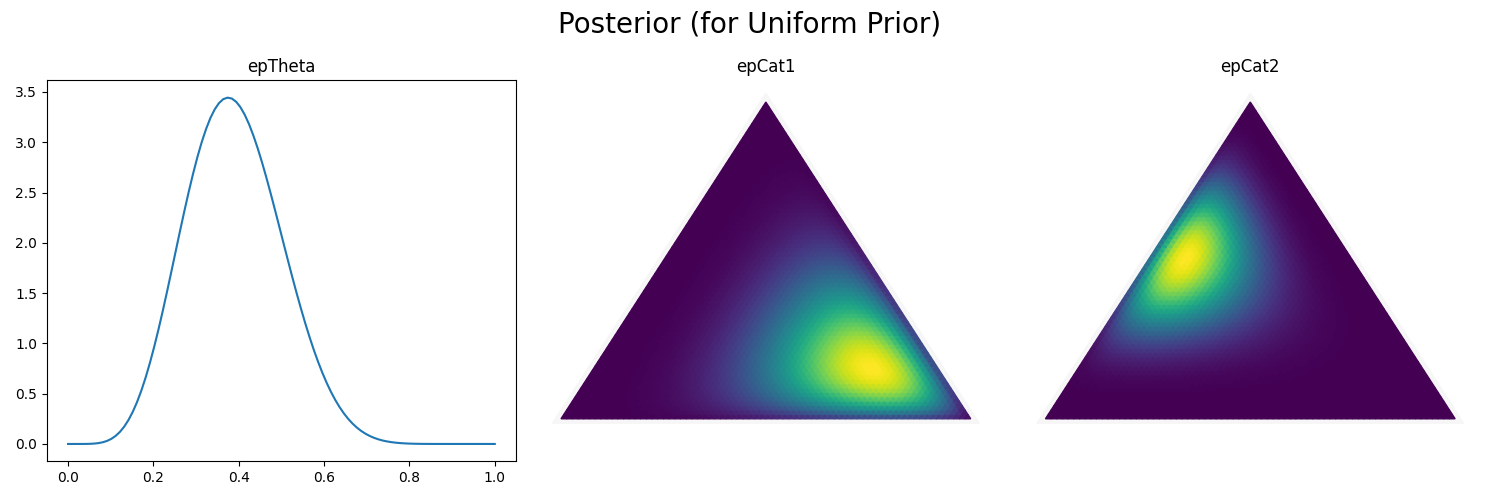

In [22]:
displayPNG 0 0 $ plotExampleParams' "Posterior (for Uniform Prior)" posteriorU

## Evaluation

How much did we learn? The goal of learning is to increase the probability of the (frequent) observations compared, while lowering the probability of samples that were not (or rarely) observed. Thus, we can compare the probabilities of observations vs non-observations (simulated by samples drawn from the prior) under the prior predictive vs the posterior predictive (marginalizing over the global latent variables).

In [23]:
let nObs = length observations
    nFakes = nObs
fakes <- replicateM nFakes $ do
  probs <- sample (sampleProbs @ExampleParams priorJ) gen
  sampleTrace probs exampleLk gen

In [24]:
let fakeLogPsPrior    = mapMaybe
      (\(_, trace) -> snd <$> evalTracePredLogP priorJ trace exampleLk)
      fakes
    fakeLogPsPosterior = mapMaybe
      (\(_, trace) -> snd <$> evalTracePredLogP posteriorJ trace exampleLk)
      fakes
    obsLogPsPrior = mapMaybe
      (\trace -> snd <$> evalTracePredLogP priorJ trace exampleLk)
      observations
    obsLogPsPosterior = mapMaybe
      (\trace -> snd <$> evalTracePredLogP posteriorJ trace exampleLk)
      observations

In [25]:
  putStrLn "before learning:"
  putStrLn $ "  mean prior logp (fakes):     " <> show
    (sum fakeLogPsPrior / nFakes)
  putStrLn $ "  mean prior logp (obs):       " <> show (sum obsLogPsPrior / fromIntegral nObs)
  putStrLn "after learning:"
  putStrLn $ "  mean posterior logp (fakes): " <> show
    (sum fakeLogPsPosterior / nFakes)
  putStrLn $ "  mean posterior logp (obs):   " <> show
    (sum obsLogPsPosterior / fromIntegral nObs)

before learning:

: 

As you can see, learning reduced the average (log) probability of random samples while increasing the average (log) probability of the observations.

In [26]:
plotProbabilities title obsPri obsPost fakePri fakePost =
  Plt.readData ((obsPri, obsPost, fakePri, fakePost), title) 
  Plt.% Plt.mp Plt.# "import numpy as np"
  Plt.% Plt.mp Plt.# "import pandas as pd"
  Plt.% Plt.mp Plt.# "import seaborn as sns"
  Plt.% Plt.mp Plt.# "obsPri, obsPost, fakePri, fakePost = tuple(map(np.array, data[0]))"
  Plt.% Plt.mp Plt.# "title = data[1]"
  Plt.% Plt.mp Plt.# "df = pd.DataFrame()"
  Plt.% Plt.mp Plt.# "df['logp'] = np.concatenate((obsPri, obsPost, fakePri, fakePost))"
  Plt.% Plt.mp Plt.# "df['dist'] = np.concatenate((np.full(len(obsPri), 'obsPrior'), np.full(len(obsPost), 'obsPosterior'), np.full(len(fakePri), 'fakePrior'), np.full(len(fakePost), 'fakePosterior')))"
  Plt.% Plt.mp Plt.# "df.plot()"
  Plt.% Plt.mp Plt.# "fig, ax = plot.subplots(2, 1, figsize=(10,5))"
  Plt.% Plt.mp Plt.# "sns.scatterplot(data=df, x='logp', y='dist', ax=ax[0])"
  Plt.% Plt.mp Plt.# "sns.kdeplot(data=df[np.logical_or(df.dist=='obsPosterior', df.dist=='fakePosterior')], x='logp', hue='dist', ax=ax[1])"
  Plt.% Plt.mp Plt.# "fig.suptitle(title, fontsize=20)"
--  Plt.% Plt.mp Plt.# "fig.tight_layout()"

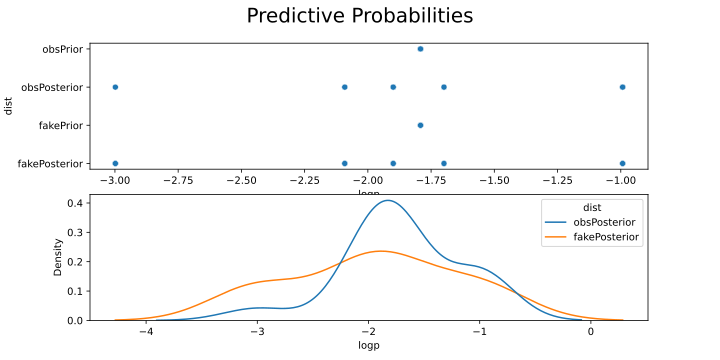

In [27]:
plotProbabilities "Predictive Probabilities" obsLogPsPrior obsLogPsPosterior fakeLogPsPrior fakeLogPsPosterior

In the plot, you can see that the prior assings slightly higher probability to the observations than to the randomly sampled data, while the prior gives all samples the same probability. (Note that there are only 6 different possible outcomes here, so there can be at most 6 different probilities under the same distribution.)